# Library

In [51]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from scipy.stats import norm, kstest
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

import warnings
warnings.filterwarnings('ignore')

# Data

In [52]:
tickers = ['TSLA', 'BABA', 'QCOM']

In [53]:
stocks_df = yf.download(tickers, start="2023-12-01", end="2024-11-30")['Close']

stocks_df.index = pd.to_datetime(stocks_df.index)

# Tampilkan DataFrame yang telah digabung
stocks_df

[*********************100%***********************]  3 of 3 completed


Ticker,BABA,QCOM,TSLA
Date,,,
2023-12-01,73.989998,129.669998,238.830002
2023-12-04,73.029999,129.949997,235.580002
2023-12-05,72.379997,130.750000,238.720001
2023-12-06,71.489998,129.960007,239.369995
2023-12-07,72.330002,132.940002,242.639999
...,...,...,...
2024-11-22,83.129997,156.789993,352.559998
2024-11-25,85.580002,158.820007,338.589996
2024-11-26,85.180000,156.929993,338.230011


# Log Return

In [54]:
# log_returns =  np.log(stocks_df / stocks_df.shift(1)).dropna()
log_returns =  np.log(stocks_df / stocks_df.shift(1)).dropna()
log_returns

Ticker,BABA,QCOM,TSLA
Date,,,
2023-12-04,-0.013060,0.002157,-0.013701
2023-12-05,-0.008940,0.006137,0.013241
2023-12-06,-0.012372,-0.006060,0.002719
2023-12-07,0.011681,0.022671,0.013568
2023-12-08,-0.002630,0.000226,0.004933
...,...,...,...
2024-11-22,-0.029046,0.008519,0.037335
2024-11-25,0.029046,0.012864,-0.040431
2024-11-26,-0.004685,-0.011972,-0.001064


In [55]:
log_returns.index = pd.to_datetime(log_returns.index)

In [56]:
# Gabungkan log returns dengan stocks_df_cut
combined_df = pd.concat([stocks_df, log_returns], axis=1)

# Ubah nama kolom agar lebih jelas
combined_df.columns = [f'{col}_Close' if i < len(stocks_df.columns) else f'{col}_LogReturn' 
                       for i, col in enumerate(stocks_df.columns.append(log_returns.columns))]

# Tampilkan DataFrame yang sudah digabung
combined_df

,BABA_Close,QCOM_Close,TSLA_Close,BABA_LogReturn,QCOM_LogReturn,TSLA_LogReturn
Date,,,,,,
2023-12-01,73.989998,129.669998,238.830002,NaN,NaN,NaN
2023-12-04,73.029999,129.949997,235.580002,-0.013060,0.002157,-0.013701
2023-12-05,72.379997,130.750000,238.720001,-0.008940,0.006137,0.013241
2023-12-06,71.489998,129.960007,239.369995,-0.012372,-0.006060,0.002719
2023-12-07,72.330002,132.940002,242.639999,0.011681,0.022671,0.013568
...,...,...,...,...,...,...
2024-11-22,83.129997,156.789993,352.559998,-0.029046,0.008519,0.037335
2024-11-25,85.580002,158.820007,338.589996,0.029046,0.012864,-0.040431
2024-11-26,85.180000,156.929993,338.230011,-0.004685,-0.011972,-0.001064


In [57]:
combined_df.describe()

,BABA_Close,QCOM_Close,TSLA_Close,BABA_LogReturn,QCOM_LogReturn,TSLA_LogReturn
count,251.000000,251.000000,251.000000,250.000000,250.000000,250.000000
mean,80.671394,169.580319,216.424462,0.000665,0.000804,0.001473
std,10.504052,20.741228,43.488166,0.023200,0.024137,0.038126
min,68.050003,129.669998,142.050003,-0.069041,-0.098354,-0.131643
25%,73.535000,156.859993,180.000000,-0.012904,-0.011663,-0.019282
50%,76.980003,168.100006,210.660004,0.000489,0.002187,0.000713
75%,83.700001,175.645004,241.845001,0.013744,0.013977,0.019295
max,117.519997,227.089996,352.559998,0.095919,0.092975,0.198187


In [58]:
combined_df.to_csv('stocks_and_log_returns.csv')

In [59]:
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show, output_file

# Prepare the output file
output_file("stock_prices_log_returns.html")

# Create a list to hold all the plots
plots = []

# Define the companies and their respective colors
companies = {
    'BABA': 'blue',
    'QCOM': 'orange',
    'TSLA': 'green',
}

# Iterate over each company to create plots
for company, color in companies.items():
    # Create a ColumnDataSource
    source = ColumnDataSource(data={
        'date': combined_df.index,
        'close': combined_df[f'{company}_Close'],
        'log_return': combined_df[f'{company}_LogReturn']
    })

    # Create the closing price plot
    p_close = figure(x_axis_type='datetime', title=f'{company} Closing Price')
    p_close.line('date', 'close', source=source, color=color, legend_label=f'{company} Close')
    p_close.add_tools(HoverTool(
        tooltips=[
            ('Date', '@date{%F}'),
            ('Close', '@close{0.2f}')
        ],
        formatters={'@date': 'datetime'},
        mode='vline'
    ))
    p_close.legend.location = 'top_left'
    p_close.xaxis.axis_label = 'Date'
    p_close.yaxis.axis_label = 'Price'
    plots.append(p_close)

    # Create the log return plot
    p_log_return = figure(x_axis_type='datetime', title=f'{company} Log Return')
    p_log_return.line('date', 'log_return', source=source, color=color, legend_label=f'{company} Log Return')
    p_log_return.add_tools(HoverTool(
        tooltips=[
            ('Date', '@date{%F}'),
            ('Log Return', '@log_return{0.4f}')
        ],
        formatters={'@date': 'datetime'},
        mode='vline'
    ))
    p_log_return.legend.location = 'top_left'
    p_log_return.xaxis.axis_label = 'Date'
    p_log_return.yaxis.axis_label = 'Log Return'
    plots.append(p_log_return)

# Arrange plots in a 2x3 grid
grid = gridplot([plots[:3], plots[3:]], sizing_mode='stretch_both')

# Show the grid
show(grid)


# Plot ACF & PACF

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def uji_acf_pacf(log_returns, tickers):
    
    for ticker in tickers:
        print(f"Uji ACF untuk {ticker}")
        
        # Plot ACF
        plt.figure(figsize=(10, 6))
        plot_acf(log_returns[ticker], lags=50)
        plt.title(f'ACF untuk {ticker}')
        plt.show()

        print(f"Uji PACF untuk {ticker}")
        
        # Plot PACF
        plt.figure(figsize=(10, 6))
        plot_pacf(log_returns[ticker], lags=50)
        plt.title(f'PACF untuk {ticker}')
        plt.show()

Uji ACF untuk TSLA


<Figure size 1000x600 with 0 Axes>

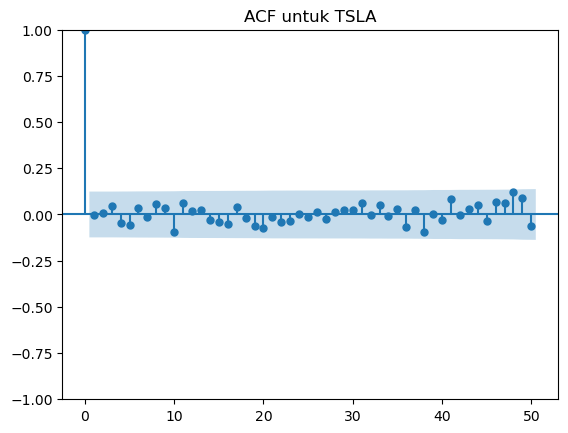

Uji PACF untuk TSLA


<Figure size 1000x600 with 0 Axes>

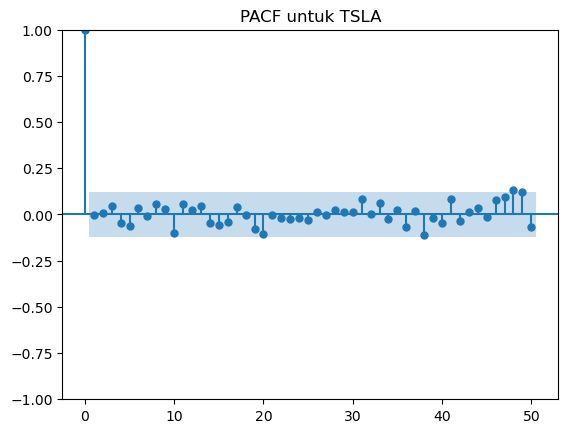

Uji ACF untuk BABA


<Figure size 1000x600 with 0 Axes>

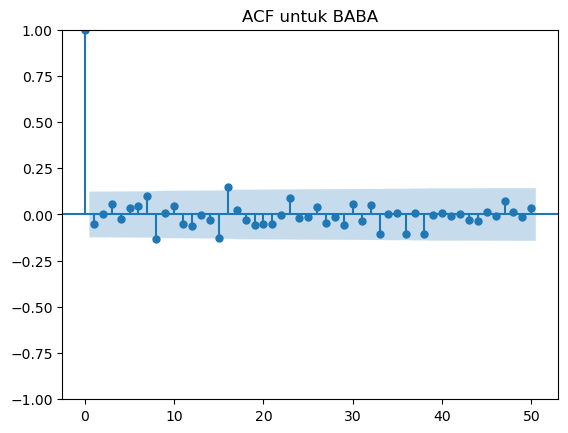

Uji PACF untuk BABA


<Figure size 1000x600 with 0 Axes>

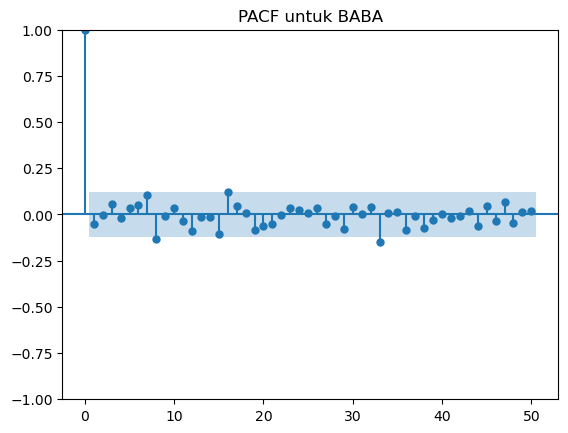

Uji ACF untuk QCOM


<Figure size 1000x600 with 0 Axes>

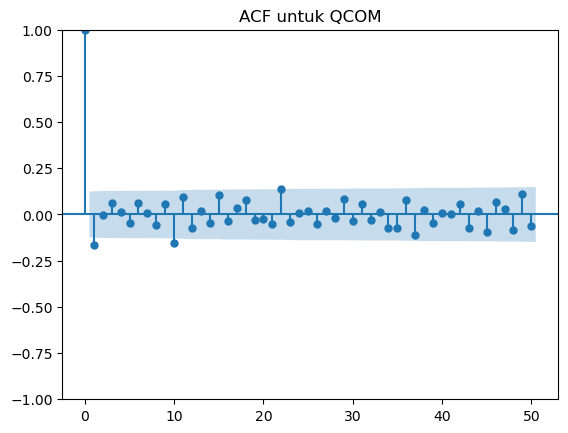

Uji PACF untuk QCOM


<Figure size 1000x600 with 0 Axes>

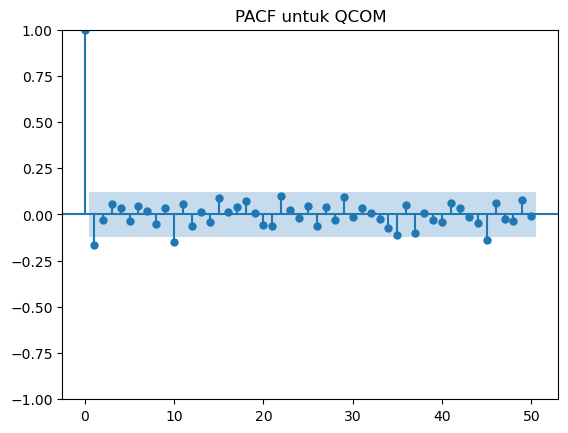

In [61]:
# Panggil fungsi uji ACF dan PACF
uji_acf_pacf(log_returns, tickers)

# Uji Normalitas Return: Kolmogorov-Smirnov

In [62]:
# Langkah 3: Uji Normalitas (Kolmogorov-Smirnov)
def kolmogorov_smirnov_test(data):
    # Uji Kolmogorov-Smirnov terhadap distribusi normal
    stat, p_value = kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"KS Test Statistic: {stat}, p-value: {p_value}")
    if p_value < 0.05:
        print("Data tidak berdistribusi normal")
    else:
        print("Data berdistribusi normal")
    print("")

# Uji normalitas untuk masing-masing saham
for ticker in tickers:
    print(f"Uji Normalitas untuk {ticker}")
    kolmogorov_smirnov_test(log_returns[ticker])


Uji Normalitas untuk TSLA
KS Test Statistic: 0.0785303213361207, p-value: 0.08678202644806865
Data berdistribusi normal

Uji Normalitas untuk BABA
KS Test Statistic: 0.05549351439258132, p-value: 0.4098001288130556
Data berdistribusi normal

Uji Normalitas untuk QCOM
KS Test Statistic: 0.06332566713304377, p-value: 0.2576147051493286
Data berdistribusi normal



# Uji Stastioneritas

In [63]:
# Fungsi untuk uji Augmented Dickey-Fuller (ADF) untuk stasioneritas
def uji_adf(time_series):
    # Menjalankan uji ADF
    result = adfuller(time_series)
    
    # Menampilkan hasil uji ADF
    print(f"Statistik ADF: {result[0]}")
    print(f"p-value: {result[1]}")
    
    # Menginterpretasikan hasil uji
    if result[1] < 0.05:
        print("Data stasioner: p-value < 0.05, hipotesis nol ditolak")
    else:
        print("Data tidak stasioner: p-value >= 0.05, hipotesis nol diterima")
    print("")

for ticker in tickers:
    uji_adf(log_returns[ticker])

Statistik ADF: -15.742778521871589
p-value: 1.2500670828946837e-28
Data stasioner: p-value < 0.05, hipotesis nol ditolak

Statistik ADF: -16.60078514829446
p-value: 1.765287582278193e-29
Data stasioner: p-value < 0.05, hipotesis nol ditolak

Statistik ADF: -18.56528327576993
p-value: 2.085322483072653e-30
Data stasioner: p-value < 0.05, hipotesis nol ditolak



# AR

In [64]:
# Fungsi untuk membangun dan menyesuaikan model AR
def ar_model(data, lags=1):
    # Membangun model AR dengan menggunakan lags tertentu (misalnya, p=1 untuk AR(1))
    model = AutoReg(data, lags=lags)
    model_fit = model.fit()
    print("")
    return model_fit


# residuals_df[ticker] = residuals

In [65]:
results = []
residuals_df = pd.DataFrame()

In [66]:
# Function to perform diagnostic tests on residuals
def diagnostic_tests(residuals):
    # Normality Tests (Kolmogorov-Smirnov Test)
    ks_stat, ks_p_value = kstest((residuals - residuals.mean()) / residuals.std(), 'norm')
    
    # Autocorrelation Test (Ljung-Box)
    lb_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
    lb_stat = lb_result["lb_stat"].values[0]
    lb_p_value = lb_result["lb_pvalue"].values[0]
    
    # ARCH Test (Heteroskedasticity Test)
    arch_stat, arch_p_value, _, _ = het_arch(residuals)
    
    # Return the test statistics and p-values
    return {
        'KS Test Statistic': ks_stat,
        'KS p-value': ks_p_value,
        'Ljung-Box Test Statistic': lb_stat,
        'Ljung-Box p-value': lb_p_value,
        'ARCH LM Test Statistic': arch_stat,
        'ARCH LM p-value': arch_p_value
    }

## BABA

In [67]:
ticker = 'BABA'

P_AR = 8

model = ar_model(log_returns[ticker], lags=P_AR)
print(model.summary())  # Menampilkan ringkasan hasil model

# Langkah berikutnya bisa dilakukan sesuai dengan analisis residual atau prediksi
residuals = model.resid  # Mendapatkan residual dari model AR

residuals_df[f"{ticker} - AR({P_AR})"] = residuals

diag_results = diagnostic_tests(residuals)

# Get parameters dynamically
param_results = {f'Parameter {i}': param for i, param in enumerate(model.params, 0)}

# Append the results for each ticker
results.append({
    'Ticker': f"{ticker} - AR({P_AR})",
    **diag_results,  # Add diagnostic results
})

# Convert results list to DataFrame
results_ar_df = pd.DataFrame(results)
results_ar_df = results_ar_df.rename(columns={'Parameter 0': 'Constant'})

# Significance level
alpha = 0.05

# Function to determine check or cross mark
def check_mark(p_value):
    return '✓' if p_value > alpha else '✗'

# Apply function to each p-value column to create new indicator columns
results_ar_df['Normal'] = results_ar_df['KS p-value'].apply(check_mark)
results_ar_df['Independent'] = results_ar_df['Ljung-Box p-value'].apply(check_mark)

# Untuk kolom Homoskedastic, membalikkan logika tanda
results_ar_df['Heteroskedastisitas'] = results_ar_df['ARCH LM p-value'].apply(lambda p: '✗' if p > alpha else '✓')


                            AutoReg Model Results                             
Dep. Variable:                   BABA   No. Observations:                  250
Model:                     AutoReg(8)   Log Likelihood                 569.472
Method:               Conditional MLE   S.D. of innovations              0.023
Date:                Mon, 09 Dec 2024   AIC                          -1118.943
Time:                        21:00:31   BIC                          -1084.054
Sample:                             8   HQIC                         -1104.889
                                  250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.533      0.594      -0.002       0.004
BABA.L1       -0.0464      0.064     -0.727      0.467      -0.171       0.079
BABA.L2        0.0025      0.064      0.039      0.

In [68]:
ticker = 'BABA'

P_AR = 33

model = ar_model(log_returns[ticker], lags=P_AR)
print(model.summary())  # Menampilkan ringkasan hasil model

# Langkah berikutnya bisa dilakukan sesuai dengan analisis residual atau prediksi
residuals = model.resid  # Mendapatkan residual dari model AR

residuals_df[f"{ticker} - AR({P_AR})"] = residuals

diag_results = diagnostic_tests(residuals)

# Get parameters dynamically
param_results = {f'Parameter {i}': param for i, param in enumerate(model.params, 0)}

# Append the results for each ticker
results.append({
    'Ticker': f"{ticker} - AR({P_AR})",
    **diag_results,  # Add diagnostic results
})

# Convert results list to DataFrame
results_ar_df = pd.DataFrame(results)
results_ar_df = results_ar_df.rename(columns={'Parameter 0': 'Constant'})

# Significance level
alpha = 0.05

# Function to determine check or cross mark
def check_mark(p_value):
    return '✓' if p_value > alpha else '✗'

# Apply function to each p-value column to create new indicator columns
results_ar_df['Normal'] = results_ar_df['KS p-value'].apply(check_mark)
results_ar_df['Independent'] = results_ar_df['Ljung-Box p-value'].apply(check_mark)

# Untuk kolom Homoskedastic, membalikkan logika tanda
results_ar_df['Heteroskedastisitas'] = results_ar_df['ARCH LM p-value'].apply(lambda p: '✗' if p > alpha else '✓')


                            AutoReg Model Results                             
Dep. Variable:                   BABA   No. Observations:                  250
Model:                    AutoReg(33)   Log Likelihood                 518.999
Method:               Conditional MLE   S.D. of innovations              0.022
Date:                Mon, 09 Dec 2024   AIC                           -967.998
Time:                        21:00:31   BIC                           -849.701
Sample:                            33   HQIC                          -920.211
                                  250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      1.094      0.274      -0.001       0.005
BABA.L1       -0.0100      0.067     -0.149      0.881      -0.141       0.121
BABA.L2       -0.0154      0.067     -0.231      0.

### Model AIC Terbaik

In [69]:
ticker = 'BABA'

P_AR = 1

model = ar_model(log_returns[ticker], lags=P_AR)
print(model.summary())  # Menampilkan ringkasan hasil model

# Langkah berikutnya bisa dilakukan sesuai dengan analisis residual atau prediksi
residuals = model.resid  # Mendapatkan residual dari model AR

residuals_df[f"{ticker} - AR({P_AR})"] = residuals

diag_results = diagnostic_tests(residuals)

# Get parameters dynamically
param_results = {f'Parameter {i}': param for i, param in enumerate(model.params, 0)}

# Append the results for each ticker
results.append({
    'Ticker': f"{ticker} - AR({P_AR})",
    **diag_results,  # Add diagnostic results
})

# Convert results list to DataFrame
results_ar_df = pd.DataFrame(results)
results_ar_df = results_ar_df.rename(columns={'Parameter 0': 'Constant'})

# Significance level
alpha = 0.05

# Function to determine check or cross mark
def check_mark(p_value):
    return '✓' if p_value > alpha else '✗'

# Apply function to each p-value column to create new indicator columns
results_ar_df['Normal'] = results_ar_df['KS p-value'].apply(check_mark)
results_ar_df['Independent'] = results_ar_df['Ljung-Box p-value'].apply(check_mark)

# Untuk kolom Homoskedastic, membalikkan logika tanda
results_ar_df['Heteroskedastisitas'] = results_ar_df['ARCH LM p-value'].apply(lambda p: '✗' if p > alpha else '✓')


                            AutoReg Model Results                             
Dep. Variable:                   BABA   No. Observations:                  250
Model:                     AutoReg(1)   Log Likelihood                 584.365
Method:               Conditional MLE   S.D. of innovations              0.023
Date:                Mon, 09 Dec 2024   AIC                          -1162.729
Time:                        21:00:31   BIC                          -1152.177
Sample:                             1   HQIC                         -1158.482
                                  250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.514      0.607      -0.002       0.004
BABA.L1       -0.0543      0.063     -0.858      0.391      -0.178       0.070
                                    Roots          

## QCOM

In [70]:
ticker = 'QCOM'

P_AR = 1

model = ar_model(log_returns[ticker], lags=P_AR)
print(model.summary())  # Menampilkan ringkasan hasil model

# Langkah berikutnya bisa dilakukan sesuai dengan analisis residual atau prediksi
residuals = model.resid  # Mendapatkan residual dari model AR

residuals_df[f"{ticker} - AR({P_AR})"] = residuals

diag_results = diagnostic_tests(residuals)

# Get parameters dynamically
param_results = {f'Parameter {i}': param for i, param in enumerate(model.params, 0)}

# Append the results for each ticker
results.append({
    'Ticker': f"{ticker} - AR({P_AR})",
    **diag_results,  # Add diagnostic results
})

# Convert results list to DataFrame
results_ar_df = pd.DataFrame(results)
results_ar_df = results_ar_df.rename(columns={'Parameter 0': 'Constant'})

# Significance level
alpha = 0.05

# Function to determine check or cross mark
def check_mark(p_value):
    return '✓' if p_value > alpha else '✗'

# Apply function to each p-value column to create new indicator columns
results_ar_df['Normal'] = results_ar_df['KS p-value'].apply(check_mark)
results_ar_df['Independent'] = results_ar_df['Ljung-Box p-value'].apply(check_mark)

# Untuk kolom Homoskedastic, membalikkan logika tanda
results_ar_df['Heteroskedastisitas'] = results_ar_df['ARCH LM p-value'].apply(lambda p: '✗' if p > alpha else '✓')


                            AutoReg Model Results                             
Dep. Variable:                   QCOM   No. Observations:                  250
Model:                     AutoReg(1)   Log Likelihood                 577.425
Method:               Conditional MLE   S.D. of innovations              0.024
Date:                Mon, 09 Dec 2024   AIC                          -1148.851
Time:                        21:00:32   BIC                          -1138.298
Sample:                             1   HQIC                         -1144.603
                                  250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.612      0.541      -0.002       0.004
QCOM.L1       -0.1656      0.063     -2.649      0.008      -0.288      -0.043
                                    Roots          

In [71]:
ticker = 'QCOM'

P_AR = 10

model = ar_model(log_returns[ticker], lags=P_AR)
print(model.summary())  # Menampilkan ringkasan hasil model

# Langkah berikutnya bisa dilakukan sesuai dengan analisis residual atau prediksi
residuals = model.resid  # Mendapatkan residual dari model AR

residuals_df[f"{ticker} - AR({P_AR})"] = residuals

diag_results = diagnostic_tests(residuals)

# Get parameters dynamically
param_results = {f'Parameter {i}': param for i, param in enumerate(model.params, 0)}

# Append the results for each ticker
results.append({
    'Ticker': f"{ticker} - AR({P_AR})",
    **diag_results,  # Add diagnostic results
})

# Convert results list to DataFrame
results_ar_df = pd.DataFrame(results)
results_ar_df = results_ar_df.rename(columns={'Parameter 0': 'Constant'})

# Significance level
alpha = 0.05

# Function to determine check or cross mark
def check_mark(p_value):
    return '✓' if p_value > alpha else '✗'

# Apply function to each p-value column to create new indicator columns
results_ar_df['Normal'] = results_ar_df['KS p-value'].apply(check_mark)
results_ar_df['Independent'] = results_ar_df['Ljung-Box p-value'].apply(check_mark)

# Untuk kolom Homoskedastic, membalikkan logika tanda
results_ar_df['Heteroskedastisitas'] = results_ar_df['ARCH LM p-value'].apply(lambda p: '✗' if p > alpha else '✓')


                            AutoReg Model Results                             
Dep. Variable:                   QCOM   No. Observations:                  250
Model:                    AutoReg(10)   Log Likelihood                 558.276
Method:               Conditional MLE   S.D. of innovations              0.024
Date:                Mon, 09 Dec 2024   AIC                          -1092.551
Time:                        21:00:32   BIC                          -1050.783
Sample:                            10   HQIC                         -1075.722
                                  250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.401      0.688      -0.002       0.004
QCOM.L1       -0.1659      0.064     -2.600      0.009      -0.291      -0.041
QCOM.L2       -0.0327      0.065     -0.506      0.

In [72]:
ticker = 'QCOM'

P_AR = 45

model = ar_model(log_returns[ticker], lags=P_AR)
print(model.summary())  # Menampilkan ringkasan hasil model

# Langkah berikutnya bisa dilakukan sesuai dengan analisis residual atau prediksi
residuals = model.resid  # Mendapatkan residual dari model AR

residuals_df[f"{ticker} - AR({P_AR})"] = residuals

diag_results = diagnostic_tests(residuals)

# Get parameters dynamically
param_results = {f'Parameter {i}': param for i, param in enumerate(model.params, 0)}

# Append the results for each ticker
results.append({
    'Ticker': f"{ticker} - AR({P_AR})",
    **diag_results,  # Add diagnostic results
})

# Convert results list to DataFrame
results_ar_df = pd.DataFrame(results)
results_ar_df = results_ar_df.rename(columns={'Parameter 0': 'Constant'})

# Significance level
alpha = 0.05

# Function to determine check or cross mark
def check_mark(p_value):
    return '✓' if p_value > alpha else '✗'

# Apply function to each p-value column to create new indicator columns
results_ar_df['Normal'] = results_ar_df['KS p-value'].apply(check_mark)
results_ar_df['Independent'] = results_ar_df['Ljung-Box p-value'].apply(check_mark)

# Untuk kolom Homoskedastic, membalikkan logika tanda
results_ar_df['Heteroskedastisitas'] = results_ar_df['ARCH LM p-value'].apply(lambda p: '✗' if p > alpha else '✓')


                            AutoReg Model Results                             
Dep. Variable:                   QCOM   No. Observations:                  250
Model:                    AutoReg(45)   Log Likelihood                 487.452
Method:               Conditional MLE   S.D. of innovations              0.022
Date:                Mon, 09 Dec 2024   AIC                           -880.904
Time:                        21:00:32   BIC                           -724.722
Sample:                            45   HQIC                          -817.732
                                  250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.339      0.734      -0.003       0.004
QCOM.L1       -0.1818      0.069     -2.646      0.008      -0.317      -0.047
QCOM.L2       -0.0822      0.070     -1.183      0.

## TSLA

In [73]:
ticker = 'TSLA'

P_AR = 48

model = ar_model(log_returns[ticker], lags=P_AR)
print(model.summary())  # Menampilkan ringkasan hasil model

# Langkah berikutnya bisa dilakukan sesuai dengan analisis residual atau prediksi
residuals = model.resid  # Mendapatkan residual dari model AR

residuals_df[f"{ticker} - AR({P_AR})"] = residuals

diag_results = diagnostic_tests(residuals)

# Get parameters dynamically
param_results = {f'Parameter {i}': param for i, param in enumerate(model.params, 0)}

# Append the results for each ticker
results.append({
    'Ticker': f"{ticker} - AR({P_AR})",
    **diag_results,  # Add diagnostic results
})

# Convert results list to DataFrame
results_ar_df = pd.DataFrame(results)
results_ar_df = results_ar_df.rename(columns={'Parameter 0': 'Constant'})

# Significance level
alpha = 0.05

# Function to determine check or cross mark
def check_mark(p_value):
    return '✓' if p_value > alpha else '✗'

# Apply function to each p-value column to create new indicator columns
results_ar_df['Normal'] = results_ar_df['KS p-value'].apply(check_mark)
results_ar_df['Independent'] = results_ar_df['Ljung-Box p-value'].apply(check_mark)

# Untuk kolom Homoskedastic, membalikkan logika tanda
results_ar_df['Heteroskedastisitas'] = results_ar_df['ARCH LM p-value'].apply(lambda p: '✗' if p > alpha else '✓')


                            AutoReg Model Results                             
Dep. Variable:                   TSLA   No. Observations:                  250
Model:                    AutoReg(48)   Log Likelihood                 383.096
Method:               Conditional MLE   S.D. of innovations              0.036
Date:                Mon, 09 Dec 2024   AIC                           -666.193
Time:                        21:00:32   BIC                           -500.779
Sample:                            48   HQIC                          -599.266
                                  250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.003      1.360      0.174      -0.002       0.009
TSLA.L1       -0.0301      0.069     -0.435      0.664      -0.166       0.106
TSLA.L2       -0.0135      0.069     -0.197      0.

### Model AIC Terbaik

In [74]:
ticker = 'TSLA'

P_AR = 1

model = ar_model(log_returns[ticker], lags=P_AR)
print(model.summary())  # Menampilkan ringkasan hasil model

# Langkah berikutnya bisa dilakukan sesuai dengan analisis residual atau prediksi
residuals = model.resid  # Mendapatkan residual dari model AR

residuals_df[f"{ticker} - AR({P_AR})"] = residuals

diag_results = diagnostic_tests(residuals)

# Get parameters dynamically
param_results = {f'Parameter {i}': param for i, param in enumerate(model.params, 0)}

# Append the results for each ticker
results.append({
    'Ticker': f"{ticker} - AR({P_AR})",
    **diag_results,  # Add diagnostic results
})

# Convert results list to DataFrame
results_ar_df = pd.DataFrame(results)
results_ar_df = results_ar_df.rename(columns={'Parameter 0': 'Constant'})

# Significance level
alpha = 0.05

# Function to determine check or cross mark
def check_mark(p_value):
    return '✓' if p_value > alpha else '✗'

# Apply function to each p-value column to create new indicator columns
results_ar_df['Normal'] = results_ar_df['KS p-value'].apply(check_mark)
results_ar_df['Independent'] = results_ar_df['Ljung-Box p-value'].apply(check_mark)

# Untuk kolom Homoskedastic, membalikkzan logika tanda
results_ar_df['Heteroskedastisitas'] = results_ar_df['ARCH LM p-value'].apply(lambda p: '✗' if p > alpha else '✓')


                            AutoReg Model Results                             
Dep. Variable:                   TSLA   No. Observations:                  250
Model:                     AutoReg(1)   Log Likelihood                 460.211
Method:               Conditional MLE   S.D. of innovations              0.038
Date:                Mon, 09 Dec 2024   AIC                           -914.422
Time:                        21:00:32   BIC                           -903.870
Sample:                             1   HQIC                          -910.175
                                  250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.636      0.525      -0.003       0.006
TSLA.L1       -0.0030      0.063     -0.048      0.962      -0.127       0.121
                                    Roots          

## Results

In [75]:
ar_tests = results_ar_df[['Ticker']]
ar_tests = pd.concat([ar_tests, results_ar_df.iloc[:, 7:]], axis=1)
ar_tests

,Ticker,Normal,Independent,Heteroskedastisitas
0,BABA - AR(8),✓,✓,✓
1,BABA - AR(33),✓,✓,✗
2,BABA - AR(1),✓,✓,✓
3,QCOM - AR(1),✓,✓,✓
4,QCOM - AR(10),✓,✓,✗
5,QCOM - AR(45),✓,✓,✗
6,TSLA - AR(48),✓,✓,✗
7,TSLA - AR(1),✓,✓,✓


# ARCH

In [76]:
P_ARCH = 1


In [77]:
# Langkah 4: Model ARCH/GARCH
# Memodelkan ARCH (GARCH) untuk masing-masing saham
def arch_garch_model(data, p=1):
    model = arch_model(data, vol='ARCH', p=p, rescale=False)
    model_fit = model.fit(disp="off")
    print(model_fit.summary())
    print("\n")
    return model_fit

In [78]:
# Function to perform diagnostic tests on residuals
def diagnostic_tests(residuals):
    # Normality Tests
    ks_stat, ks_p_value = kstest((residuals - residuals.mean()) / residuals.std(), 'norm')
    
    # Autocorrelation Test (Ljung-Box)
    lb_stat = acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_stat"].values[0]
    lb_p_value= acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_pvalue"].values[0]

    # Heteroskedasticity Test (ARCH LM Test)
    arch_stat, arch_p_value, _, _ = het_arch(residuals)
    
    return ks_stat, ks_p_value, lb_stat, lb_p_value, arch_stat, arch_p_value

In [79]:
results = []

# Iterate over each ticker to fit ARCH model and perform tests
for ticker in tickers:
    # Fit ARCH(1) model
    arc_model = arch_model(residuals_df[f"{ticker} - AR({P_AR})"].dropna(), vol='ARCH', p=P_ARCH, rescale=False)
    arc_model_fit = arc_model.fit(disp="off")
    print(arc_model_fit.summary())
    
    # Obtain residuals
    residuals = arc_model_fit.resid

    param_results = {f'Parameter {i}': param for i, param in enumerate(arc_model_fit.params, 0)}
    
    # Perform diagnostic tests
    ks_stat, ks_p_value, lb_stat, lb_p_value, arch_stat, arch_p_value = diagnostic_tests(residuals)
    
    # Append results to the list
    results.append({
        'Ticker': ticker,
        'KS Test Statistic': ks_stat,
        'KS p-value': ks_p_value,
        'Ljung-Box Test Statistic': lb_stat,
        'Ljung-Box p-value': lb_p_value,
        'ARCH LM Test Statistic': arch_stat,
        'ARCH LM p-value': arch_p_value,
        **param_results
        
    })
    
# Convert results list to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.rename(columns={'Parameter 0': 'mu'})
results_df = results_df.rename(columns={'Parameter 1': 'omega'})

num_columns = len(results_df.columns)  # Or specify the number of columns you want to rename

# Create a dictionary for renaming columns
param_mapping = {}

for i in range(2, num_columns + 1):  # Assuming the parameters start from 'Parameter 2'
    param_mapping[f'Parameter {i}'] = f'alpha[{i - 1}]'

# Rename columns using the generated dictionary
results_df = results_df.rename(columns=param_mapping)


                      Constant Mean - ARCH Model Results                      
Dep. Variable:           TSLA - AR(1)   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                444.114
Distribution:                  Normal   AIC:                          -882.229
Method:            Maximum Likelihood   BIC:                          -871.762
                                        No. Observations:                  242
Date:                Mon, Dec 09 2024   Df Residuals:                      241
Time:                        21:00:32   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.9887e-05  2.676e-03 -7.431e-03      0.

## Results

In [80]:
final_results = results_df[['Ticker']]

final_results = pd.concat([final_results, results_df.iloc[:, 7:]], axis=1)

final_results


,Ticker,mu,omega,alpha[1]
0,TSLA,-0.000020,0.001491,1.321180e-16
1,BABA,0.000010,0.000527,4.163249e-02
2,QCOM,0.000079,0.000495,1.381994e-01


# VaR

In [133]:
t = 1
V0 = 10000

In [144]:
# Fungsi untuk estimasi VaR menggunakan model ARCH
def estimate_var(data):
    # Membangun model ARCH(1)
    model = arch_model(data, vol='ARCH', p=P_ARCH, rescale=False)
    model_fit = model.fit(disp="off")
    
    # Menghitung prediksi volatilitas
    volatility = model_fit.conditional_volatility

    # Ambil volatilitas t hari terakhir
    volatility_last_t_days = volatility[-t:]  # Ambil t nilai terakhir dari volatilitas

    volatility_last_t_days = volatility_last_t_days[0]
    
    # Z-score untuk confidence level alpha (misal 95% confidence level)
    z_score = norm.ppf(1 - alpha)

    # Menghitung VaR (standarized) dan VaR dalam USD
    VaR = -z_score * volatility_last_t_days * np.sqrt(t)
    VaR_USD = VaR * V0
    
    return VaR, VaR_USD

In [145]:
# DataFrame untuk menyimpan hasil estimasi VaR
results = []

# Loop untuk menghitung VaR untuk setiap ticker
for ticker in tickers:
    # Pastikan log_returns sudah ada di sini
    VaR, VaR_USD = estimate_var(residuals_df[f"{ticker} - AR({P_AR})"].dropna())

    # Menyimpan hasil dalam list
    results.append({
        'Ticker': ticker,
        'VaR': VaR,
        'VaR (USD)': VaR_USD
    })

# Mengonversi list hasil ke DataFrame setelah loop selesai
final_results_df = pd.DataFrame(results)

# Menampilkan hasil
final_results_df

,Ticker,VaR,VaR (USD)
0,TSLA,-0.063515,-635.152641
1,BABA,-0.038098,-380.981090
2,QCOM,-0.036809,-368.087682
